<a href="https://colab.research.google.com/github/jdlg-42/TFG/blob/main/distancias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install igraph
!pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 28.8 MB/s eta 0:00:00


# Código para generar grafos de PSN

In [2]:
# Sitios importantes

sites = {
    "A2A_adenosine": [168, 169, 253, 277, 278],
    "A2A_G": [102, 110, 227, 231, 235],
    "beta2AR_epi_4ldo": [1113, 1114, 1193, 1203],
    "beta2AR_epi_3sn6": [113, 114, 193, 203],
    "beta2AR_G_4ldo": [1127, 1135, 1271, 1278],
    "beta2AR_G_3sn6": [134, 135, 138, 139, 229]
    }

Para receptor A2A de adenosina:

* 2YDO: cadena A, sites["A2A_adenosine"], sites["A2A_G"]
* 5G53: cadena A, sites["A2A_adenosine"], sites["A2A_G"]

Para receptor beta-2 adrenérgico:
* 4LDO: cadena A, sites["beta2AR_epi4ldo"], sites["beta2AR_G"]
* 3SN6: cadena R, sites["beta2AR_epi3sn6"], sites["beta2AR_G"]

In [15]:
# Configuración de secuencia y sitios alostérico y ortostérico
  # modificar para analizar el grafo para cada ID específico de interés

pdb_id = "4ldo".lower()
chain_id = "A"
sitio_A = sites["beta2AR_epi_4ldo"] # sitio de unión del ligando alostérico
sitio_O = sites["beta2AR_G_4ldo"] # sitio de unión de la proteína G

In [18]:
parser = PDBParser(QUIET=True)
structure = parser.get_structure(f"{pdb_id}", f"pdb{pdb_id}.pdb")

for model in structure:
    for chain in model:
        if chain.id == chain_id:
            for residue in chain:
                for atom in residue:
                    if atom.get_name() == "CA":
                        print(residue.id[1])  # Número real del residuo

858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962
963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978
979
980
981
982
983
984
985
986
987
988
989
990
991
992
993
994
995
996
997
998
999
1000
1001
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
1020
1021
1022
1023
1024
1025
1026
1027
1028
1029
1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
1040
1041
1042
1043
1044
1045
1046
1047
1048
1049
1050
1051
1052
1053
1054
1055
1056
1057
1058
1059
1060
1061
1062
1063
1064
1065
1066
1067
1068
1069
1070
1071
1072
1073
1074
1075
1076
1077
1078
1079
1080
1081
1082
1083
1084
1085
10

[array([-38.426, -18.038, -73.987], dtype=float32), array([-38.763, -15.894, -70.846], dtype=float32), array([-35.683, -17.64 , -69.454], dtype=float32), array([-33.61 , -15.388, -67.203], dtype=float32), array([-33.09 , -17.865, -64.378], dtype=float32), array([-29.55 , -19.025, -63.588], dtype=float32), array([-28.176, -21.922, -65.666], dtype=float32), array([-29.878, -22.22 , -69.049], dtype=float32), array([-29.267, -25.427, -70.989], dtype=float32), array([-26.689, -24.564, -73.644], dtype=float32), array([-23.327, -25.485, -75.181], dtype=float32), array([-21.471, -22.43 , -73.856], dtype=float32), array([-21.764, -23.005, -70.102], dtype=float32), array([-21.206, -26.731, -70.648], dtype=float32), array([-17.925, -26.037, -72.439], dtype=float32), array([-16.939, -23.454, -69.829], dtype=float32), array([-17.34 , -26.12 , -67.143], dtype=float32), array([-15.528, -28.744, -69.221], dtype=float32), array([-12.644, -26.582, -70.459], dtype=float32), array([-12.207, -23.701, -68.0

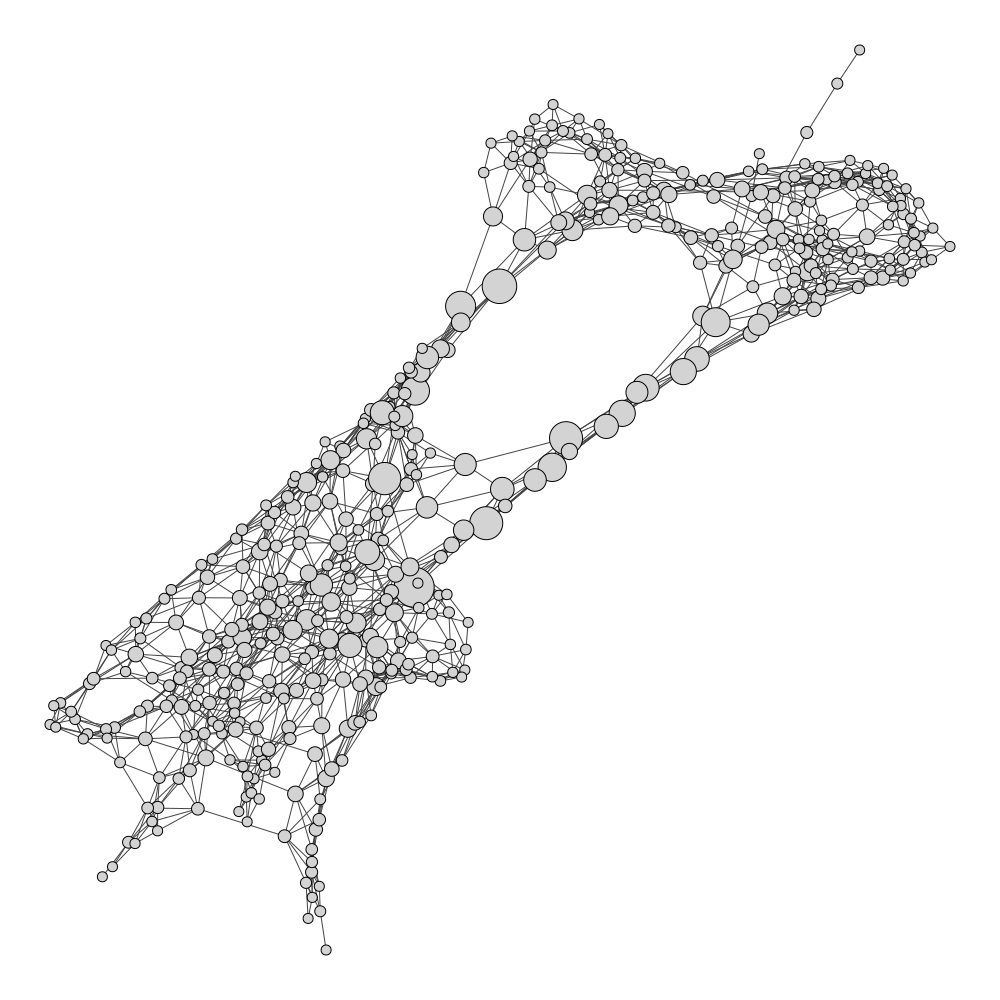

In [22]:
## Grafo de contacto de proteínas ##

# == Comandos de preparación ==

from Bio.PDB import PDBParser
from scipy.spatial import cKDTree
import numpy as np
import random
import igraph as ig
import matplotlib.pyplot as plt
from IPython.display import display, HTML

np.random.seed(42)
random.seed(42)

# Configuración de secuencia y

parser = PDBParser(QUIET=True)
structure = parser.get_structure(f"{pdb_id}", f"pdb{pdb_id}.pdb")

# === Extracción de los CA ===
CA_coord = []
CA_resnums = []  # Lista que almacena la posición de los residuos

for model in structure:
    for chain in model:
        if chain.id == chain_id:
            for residue in chain:
                for atom in residue:
                    if atom.get_name() == "CA":
                        CA_coord.append(atom.get_coord())
                        CA_resnums.append(residue.id[1])  # Número real del residuo

# El problema con la graficación es que el grafo crea los nodos empleando las
# coordenadas, y no usando su posición recogida en residue.id. Debido a ello,
# cuando buscamos graficar usando los sites definidos en el bloque de código
# anterior, dice que está fuera del rango, porque en teoría lo está.
# Para solucionar esto se me ocurre crear un diccionario que relacione
# las coordenadas (atom.get_coord) con el ID del residuo al que pertenece
# (residue.id[1]). Luego, a la hora de graficar, tiene que tener en cuenta
# el ID para seleccionar los colores, y no el orden en el que se añaden
# al grafo.

# En el código del siguiente bloque ocurre un error: muchas veces la secuencia
# peptídica sufre un processado de su extremo inicial (amina), de 6 o 7 aas.
# Esto puede producir un indexado erróneo.

# === (Opcional) Extracción del ligando ===
alig_list = []
alig_coord = []
# si deseas incluir el ligando, descomenta esta sección

# for model in structure:
#     for chain in model:
#         if chain.id != "A":
#             continue
#         for residue in chain:
#             if residue.get_resname() == "ADN" and residue.id[1] == 400:
#                 for atom in residue:
#                     alig_list.append(atom.get_id())
#                     alig_coord.append(atom.get_coord())

atom_coord = CA_coord + alig_coord

print(atom_coord)

# === Árbol de búsqueda y pares ===
tree = cKDTree(atom_coord)
atom_pairs = tree.query_pairs(r=10)

r_min = 4
r_max = 8
atom_pairsfilt = set()
for i, j in atom_pairs:
    dist = np.linalg.norm(atom_coord[i] - atom_coord[j])
    if r_min <= dist <= r_max:
        atom_pairsfilt.add((i, j))

# === Grafo ===
g = ig.Graph()
g.add_vertices(len(atom_coord))
for i, j in atom_pairsfilt:
    g.add_edge(i, j)


# === Cálculo de caminos más cortos ===

shortest_paths = []
colors = ["gold", "blue", "green", "purple", "orange", "cyan"]  # Lista de colores que se asignarán a los caminos
for a in sitio_A:
    for o in sitio_O:
        try:
            path = g.get_shortest_paths(a, to=o)[0]
            if path:
                shortest_paths.append({
                    "path": path,
                    "length": len(path),
                    "color": colors[len(shortest_paths) % len(colors)],  # Asignar un color por cada camino
                    "nodes": (a, o),
                })
        except:
            continue
print(shortest_paths)

# Calculamos el betweenness de los nodos

g.vs["betweenness"] = g.betweenness()
max_btw = max(g.vs["betweenness"])
min_btw = min(g.vs["betweenness"])

# === Añadir la métrica de centralidad a cada camino más corto ===
for path_info in shortest_paths:
    path = path_info["path"]
    centralities = [g.vs[node]["betweenness"] for node in path]
    path_info["centrality_score"] = np.mean(centralities) # se calcula la media

# === Ordenar los caminos más cortos por suma de betweenness ===
shortest_paths.sort(key=lambda x: x["centrality_score"], reverse=True)

# Escalar tamaños entre 10 y 40
g.vs["size"] = [
    10 + 30 * ((btw - min_btw) / (max_btw - min_btw + 1e-9))
    for btw in g.vs["betweenness"]
]

g.vs["color"] = ["lightgray"]
g.vs["label"] = [None] * len(g.vs)

# === Ligando ===
lig_start_idx = len(CA_coord)
lig_end_idx = lig_start_idx + len(alig_coord)
for i in range(lig_start_idx, lig_end_idx):
    g.vs[i]["color"] = "navy"
    g.vs[i]["label"] = alig_list[i - lig_start_idx]

# shortest_paths.sort(key=lambda x: x["length"])

# === Asignación de colores a los caminos más cortos ===
for idx, path_info in enumerate(shortest_paths):
    color = path_info["color"]
    path = path_info["path"]
    # Imprimir la información de cada shortest path
    print(f"Caminos más cortos entre los nodos {path_info['nodes']} (color: {color}):")
    print(f"Índice: {idx+1}")
    print(f"  Nodos involucrados: {path_info['path']}")
    print(f"  Centralidad total: {path_info['centrality_score']:.2f}")
    print(f"  Longitud del camino: {path_info['length']}")
    print(f"  Color asignado: {path_info['color']}")
    print("="*50)

# === Preguntar al usuario qué camino desea visualizar ===
try:
    selection = int(input("Introduce el número del camino más corto que deseas visualizar (0 para no representar ninguno): "))
    if 1 <= selection <= len(shortest_paths):
        chosen_path = shortest_paths[selection - 1]
        path = chosen_path["path"]
        color = chosen_path["color"]

        for node in path:
            g.vs[node]["color"] = color
            g.vs[node]["label"] = str(node)
    else:
        print("Número fuera de rango. No se coloreará ningún camino.")
except ValueError:
    print("Entrada no válida. No se coloreará ningún camino.")


# === Sitios de interés (debes definir previamente el diccionario 'sites') ===
for aa in sitio_A:
    if 0 <= aa < len(g.vs):
        g.vs[aa]["color"] = "darkred"
        g.vs[aa]["label"] = str(aa)

for aa in sitio_O:
    if 0 <= aa < len(g.vs):
        g.vs[aa]["color"] = "darkgreen"
        g.vs[aa]["label"] = str(aa)

# === Plot ===
layout = g.layout_fruchterman_reingold()
ig.plot(g, layout=layout, bbox=(1000, 1000), margin=50)

In [ ]:
top_n = 50
btw_sorted = sorted(enumerate(g.vs["betweenness"]), key=lambda x: x[1], reverse=True)
top_nodes = [idx for idx, val in btw_sorted[:top_n]]

i=1
print("Top nodos por betweenness centrality en 2YDO:")
for idx in top_nodes:
    print(f"{i}. Nodo {idx}: betweenness = {g.vs[idx]['betweenness']:.2f}")
    i+=1

Top nodos por betweenness centrality en 2YDO:
1. Nodo 49: betweenness = 2858.34
2. Nodo 248: betweenness = 2797.52
3. Nodo 250: betweenness = 2278.61
4. Nodo 78: betweenness = 2173.28
5. Nodo 88: betweenness = 2095.14
6. Nodo 208: betweenness = 2066.04
7. Nodo 259: betweenness = 2063.54
8. Nodo 209: betweenness = 2039.32
9. Nodo 168: betweenness = 1918.80
10. Nodo 75: betweenness = 1890.23
11. Nodo 179: betweenness = 1841.05
12. Nodo 39: betweenness = 1828.00
13. Nodo 86: betweenness = 1826.05
14. Nodo 54: betweenness = 1754.29
15. Nodo 85: betweenness = 1731.79
16. Nodo 205: betweenness = 1680.17
17. Nodo 257: betweenness = 1670.25
18. Nodo 93: betweenness = 1621.47
19. Nodo 87: betweenness = 1597.97
20. Nodo 24: betweenness = 1589.08
21. Nodo 216: betweenness = 1574.89
22. Nodo 215: betweenness = 1547.17
23. Nodo 154: betweenness = 1524.34
24. Nodo 252: betweenness = 1512.16
25. Nodo 38: betweenness = 1472.75
26. Nodo 167: betweenness = 1418.02
27. Nodo 251: betweenness = 1411.00
28.

In [25]:
## Grafo de contacto de proteínas ##

# == Comandos de preparación ==
from Bio.PDB import PDBParser
from scipy.spatial import cKDTree
import numpy as np
import random
import igraph as ig
import matplotlib.pyplot as plt

np.random.seed(42)
random.seed(42)

# Pruebas

pdb_id = "2ydo".lower()
chain_id = "A"
sitio_A_residues = sites["A2A_adenosine"] # sitio de unión del ligando alostérico
sitio_O_residues = sites["A2A_G"] # sitio de unión de la proteína G

# === Lectura del PDB ===
parser = PDBParser(QUIET=True)
structure = parser.get_structure(f"{pdb_id}", f"pdb{pdb_id}.pdb")

# === Extracción de los CA ===
CA_coord = []
CA_resnums = []  # Número real del residuo
for model in structure:
    for chain in model:
        if chain.id == chain_id:
            for residue in chain:
                if "CA" in residue:
                    CA_coord.append(residue["CA"].get_coord())
                    CA_resnums.append(residue.id[1])  # Número de residuo

# Crear mapeo: número de residuo → índice de nodo
resnum_to_node = {resnum: idx+1 for idx, resnum in enumerate(CA_resnums)}
print(resnum_to_node)

# === (Opcional) Extracción del ligando ===
alig_list = []
alig_coord = []

# atom_coord contiene CA + ligando (si lo hay)
atom_coord = CA_coord + alig_coord

# === Árbol de búsqueda y filtrado de pares ===
tree = cKDTree(atom_coord)
atom_pairs = tree.query_pairs(r=10)

r_min = 4
r_max = 8
atom_pairsfilt = set()
for i, j in atom_pairs:
    dist = np.linalg.norm(atom_coord[i] - atom_coord[j])
    if r_min <= dist <= r_max:
        atom_pairsfilt.add((i, j))

# === Creación del grafo ===
g = ig.Graph()
g.add_vertices(len(atom_coord))
for i, j in atom_pairsfilt:
    g.add_edge(i, j)

# === Definir sitios A y O (convertir de número de residuo a índice de nodo) ===
sitio_A = [resnum_to_node[r] for r in sitio_A_residues if r in resnum_to_node]
sitio_O = [resnum_to_node[r] for r in sitio_O_residues if r in resnum_to_node]

print(sitio_A, sitio_O)

# === Cálculo de caminos más cortos ===
shortest_paths = []
colors = ["gold", "blue", "green", "purple", "orange", "cyan"]

for a in sitio_A:
    for o in sitio_O:
        try:
            path = g.get_shortest_paths(a, to=o)[0]
            if path:
                shortest_paths.append({
                    "path": path,
                    "length": len(path),
                    "color": colors[len(shortest_paths) % len(colors)],
                    "nodes": (a, o)
                })
        except:
            continue

# === Betweenness y escalado de tamaño de nodos ===
g.vs["betweenness"] = g.betweenness()
max_btw = max(g.vs["betweenness"])
min_btw = min(g.vs["betweenness"])
g.vs["size"] = [
    10 + 30 * ((btw - min_btw) / (max_btw - min_btw + 1e-9))
    for btw in g.vs["betweenness"]
]

# === Etiquetas ===
#g.vs["label"] = [str(r) for r in CA_resnums] + [None]*len(alig_coord)
g.vs["color"] = ["lightgray"] * len(g.vs)

# === Coloreo de ligando (si lo hay) ===
lig_start_idx = len(CA_coord)
lig_end_idx = lig_start_idx + len(alig_coord)
for i in range(lig_start_idx, lig_end_idx):
    g.vs[i]["color"] = "navy"
    g.vs[i]["label"] = alig_list[i - lig_start_idx]

# === Métrica de centralidad en los caminos más cortos ===
for path_info in shortest_paths:
    path = path_info["path"]
    centralities = [g.vs[node]["betweenness"] for node in path]
    path_info["centrality_score"] = np.mean(centralities)

# Ordenar por centralidad
shortest_paths.sort(key=lambda x: x["centrality_score"], reverse=True)

# === Mostrar caminos más cortos ===
shortest_paths.sort(key=lambda x: x["length"])
for idx, path_info in enumerate(shortest_paths):
    print(f"Caminos más cortos entre los nodos {path_info['nodes']} (color: {path_info['color']}):")
    print(f"Índice: {idx+1}")
    print(f"  Nodos involucrados: {path_info['path']}")
    print(f"  Centralidad total: {path_info['centrality_score']:.2f}")
    print(f"  Longitud del camino: {path_info['length']}")
    print("="*50)

# === Selección de camino para visualización ===
try:
    selection = int(input("Introduce el número del camino más corto que deseas visualizar (0 para no representar ninguno): "))
    if 1 <= selection <= len(shortest_paths):
        chosen_path = shortest_paths[selection - 1]
        path = chosen_path["path"]
        color = chosen_path["color"]
        for node in path:
            g.vs[node]["color"] = color
            g.vs[node]["label"] = str(node)
    else:
        print("Número fuera de rango. No se coloreará ningún camino.")
except ValueError:
    print("Entrada no válida. No se coloreará ningún camino.")

# === Colorear sitios A y O ===
for aa in sitio_A:
    if 0 <= aa < len(g.vs):
        g.vs[aa]["color"] = "darkred"
        g.vs[aa]["label"] = str(aa)

for aa in sitio_O:
    if 0 <= aa < len(g.vs):
        g.vs[aa]["color"] = "darkgreen"
        g.vs[aa]["label"] = str(aa)

# === Visualización final ===
layout = g.layout_fruchterman_reingold()
ig.plot(g, layout=layout, bbox=(1000, 1000), margin=50)


{6: 1, 7: 2, 8: 3, 9: 4, 10: 5, 11: 6, 12: 7, 13: 8, 14: 9, 15: 10, 16: 11, 17: 12, 18: 13, 19: 14, 20: 15, 21: 16, 22: 17, 23: 18, 24: 19, 25: 20, 26: 21, 27: 22, 28: 23, 29: 24, 30: 25, 31: 26, 32: 27, 33: 28, 34: 29, 35: 30, 36: 31, 37: 32, 38: 33, 39: 34, 40: 35, 41: 36, 42: 37, 43: 38, 44: 39, 45: 40, 46: 41, 47: 42, 48: 43, 49: 44, 50: 45, 51: 46, 52: 47, 53: 48, 54: 49, 55: 50, 56: 51, 57: 52, 58: 53, 59: 54, 60: 55, 61: 56, 62: 57, 63: 58, 64: 59, 65: 60, 66: 61, 67: 62, 68: 63, 69: 64, 70: 65, 71: 66, 72: 67, 73: 68, 74: 69, 75: 70, 76: 71, 77: 72, 78: 73, 79: 74, 80: 75, 81: 76, 82: 77, 83: 78, 84: 79, 85: 80, 86: 81, 87: 82, 88: 83, 89: 84, 90: 85, 91: 86, 92: 87, 93: 88, 94: 89, 95: 90, 96: 91, 97: 92, 98: 93, 99: 94, 100: 95, 101: 96, 102: 97, 103: 98, 104: 99, 105: 100, 106: 101, 107: 102, 108: 103, 109: 104, 110: 105, 111: 106, 112: 107, 113: 108, 114: 109, 115: 110, 116: 111, 117: 112, 118: 113, 119: 114, 120: 115, 121: 116, 122: 117, 123: 118, 124: 119, 125: 120, 126: 

KeyboardInterrupt: Interrupted by user